Выберите одно из окружение AI Gym - Classic Control (кроме CartPole) или Box2D - https://gym.openai.com/envs/

Изучите действия агента в заданной среде. Постройте алгоритм машинного обучения с подкреплением, который решает поставленную задачу после нужного количества обучающих эпизодов.

Выложите полный код решения в вашем репозитории GitHub. Приложите ссылку на решение в репозитории в ответе к заданию.

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
env = gym.make('MountainCar-v0')

In [3]:
# Вывод информации о среде для обучения с подкреплением
print("Пространство состояний:", env.observation_space) # Выводит информацию о пространстве состояний в среде
print("Пространство действий:", env.action_space)       # Выводит информацию о пространстве действий в среде
print("Количество шагов за которое нужно решить задачу:", env._max_episode_steps)  # Выводит информацию о максимальном количестве шагов для решения задачи

Пространство состояний: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Пространство действий: Discrete(3)
Количество шагов за которое нужно решить задачу: 200


Дискретизация среды

In [4]:
# Вывод информации о нижней и верхней границах пространства состояний в среде
print ("Нижняя граница", env.observation_space.low)
print ("Верхняя граница", env.observation_space.high)

Нижняя граница [-1.2  -0.07]
Верхняя граница [0.6  0.07]


выполним дискретизацию непрерывных состояний на основе переданных значений позиции и скорости, используя модель KBinsDiscretizer из библиотеки scikit-learn. 

In [5]:
n_bins = (10, 10)
def discretizer(position, velocity):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([env.observation_space.low, env.observation_space.high])
    return tuple(map(int,est.transform([[position, velocity]])[0]))

In [6]:
print(discretizer(- 1.2, -0.07))
print(discretizer(- 0.3, 0.01))  
print(discretizer(0.6, 0.07)) 

(0, 0)
(5, 5)
(9, 9)


In [7]:
# Создадим Q-таблицу из дискретных состояний среды и возможных действий

q_table = np.zeros(n_bins + (env.action_space.n,))
q_table.shape

(10, 10, 3)

Функция policy принимает на вход текущее состояние state, объект среды env, и параметр eps, который обычно используется для параметризации эпсилон-жадной стратегии.

 С помощью np.random.random() генерируется случайное число между 0 и 1. Если это число меньше eps, то агент выбирает случайное действие из пространства возможных действий (env.action_space.sample()). Это позволяет агенту исследовать среду.

 В противном случае, агент выбирает действие с наибольшим Q-значением для данного состояния, используя q-таблицу, предполагая что такое значение там уже есть (np.argmax(q_table[state])).

Выбранное действие возвращается как результат работы функции.

Это делается для того, чтобы агент мог исследовать окружающую среду (exploration) и в то же время использовать свои текущие знания для принятия решения на основе Q-значений в q-таблице.

In [8]:
# e-жадная стратегия и обновление таблицы

def policy (state, env, eps):
    if np.random.random() < eps: 
        action = env.action_space.sample() # explore
    else:
        action = np.argmax(q_table[state])
    return action

#После выполнения этой функции Q-значение в q-таблице обновляется на основе новых полученных данных.
#Такое обновление Q-значений позволяет агенту научиться оценивать, какие действия ведут к наибольшей ожидаемой награде 
#в различных состояниях среды.
def policy_update (current_state, new_state, reward, action, lr):
    q_table[current_state][action] = (1-lr)*q_table[current_state][action] + lr*(reward + np.max(q_table[new_state]))

In [9]:
progress = []  # список для отслеживания прогресса в каждом эпизоде
avg_progress = []   # список для отслеживания среднего прогресса по эпизодам
eps = 0.1  # начальное значение параметра эпсилон
lr = 0.8   # начальное значение скорости обучения
n_episodes = 3000
for e in range(n_episodes):    # Цикл по эпизодам обучения
    if e % 1000 == 0:          # вывод информации о прогрессе на каждом 1000-м эпизоде
        print(e, 'eps', eps, 'lr', lr)
    _ = 0
    current_state, done = discretizer(*env.reset()[0]), False    # начальное состояние среды
    reward_q_t = 0                  # переменная для накопления награды во времени
    while done==False:              # непрерывный цикл - продолжаем, пока эпизод не завершен
        _ += 1                      # увеличение продолжительности текущего эпизода
        action = policy(current_state, env, eps)            # выбор действия
        obs, reward, done, trunc, info = env.step(action)   # выполнение действия в среде
        new_state = discretizer(*obs)                       # преобразование нового состояния
        if e > 900:                        # расчет награды с переменным временем
            if _ > 149: 
                reward_q_t -=1
        reward_q_t += 0.2*reward
        reward = round(reward_q_t)
        if done==True:               # модификация награды в зависимости от завершения эпизода и его продолжительности
            # reward += (200 - _)
            reward += 100
        if _ == env._max_episode_steps:
            reward *= 2
        
        policy_update(current_state, new_state, reward, action, lr) # обновление q-значения на основе полученной награды
        current_state = new_state      # обновление текущего состояния
        lr *= 0.99995                  # уменьшение скорости обучения
        eps *= 0.99995                 # уменьшение значения эпсилон
        if _ == env._max_episode_steps:  # проверка максимальной продолжительности эпизода
            break
    progress.append(_)
    avg_progress.append(np.mean(progress))

0 eps 0.1 lr 0.8


C:\Users\79082\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1000 eps 1.349545144668539e-05 lr 0.00010796361157348312
2000 eps 2.9597279364722943e-09 lr 2.3677823491778354e-08


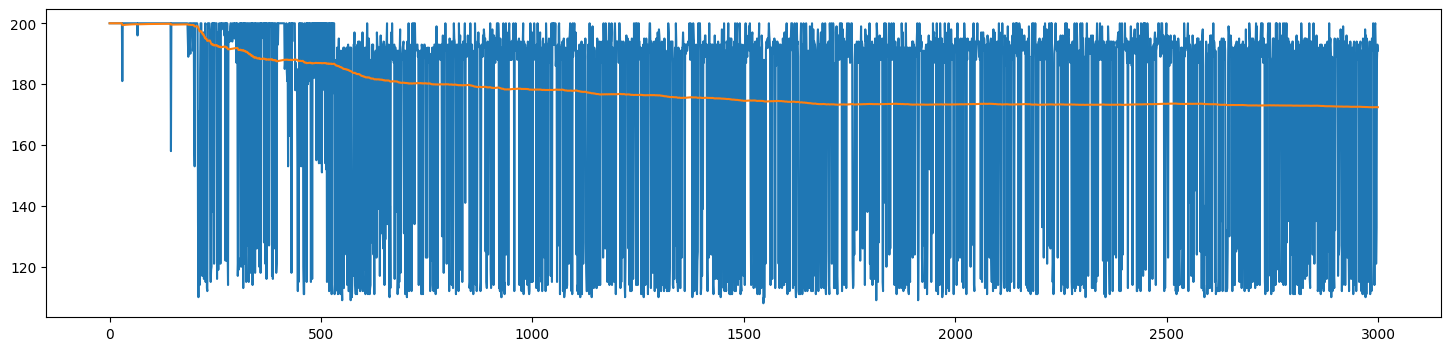

In [10]:
plt.figure(figsize=(18, 4))
plt.plot(progress)
plt.plot(avg_progress)
plt.show()

In [11]:
# Проведем 1000 попыток и вычислим среднее минимальное количество действий для достижения результата.

mean_act = []
for i in range(1000):
    eps = 0
    _ = 0
    current_state, done = discretizer(*env.reset()[0]), False
    while done==False:
        _ += 1
        action = policy(current_state, env, eps)
        obs, reward, done, trunc, info = env.step(action)
        new_state = discretizer(*obs)
        current_state = new_state
    mean_act.append(_)
env.close()

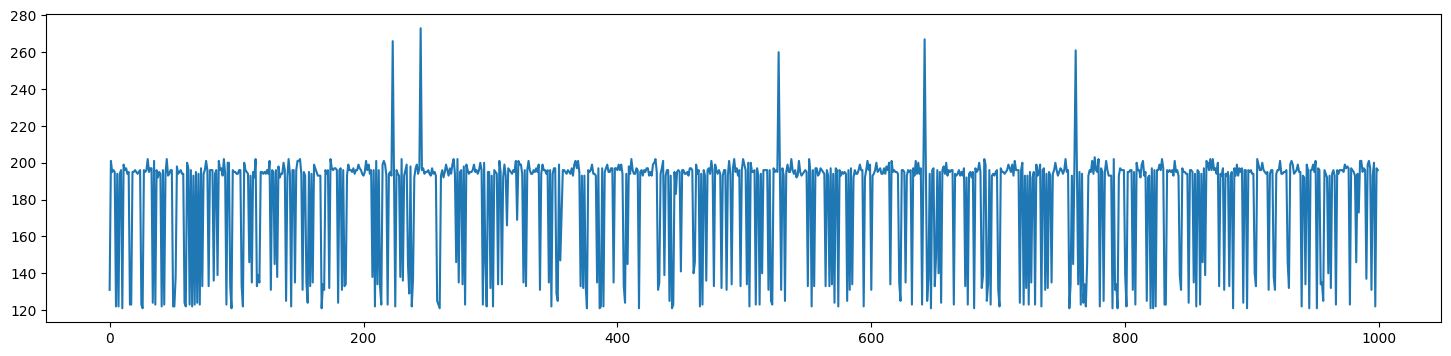

Среднее количество действий до достижения результата: 180.408


In [12]:
plt.figure(figsize=(18, 4))
plt.plot(mean_act)
plt.show()
print("Среднее количество действий до достижения результата:", np.mean(mean_act))